## from https://web.stanford.edu/~boyd/papers/admm/

# Code

In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/svm/linear_svm.html")


code =

    'function [xave, history] = linear_svm(A, lambda, p, rho, alpha)
     % linear_svm   Solve linear support vector machine (SVM) via ADMM
     %
     % [x, history] = linear_svm(A, lambda, p, rho, alpha)
     %
     % Solves the following problem via ADMM:
     %
     %   minimize   (1/2)||w||_2^2 + \lambda sum h_j(w, b)
     %
     % where A is a matrix given by [-y_j*x_j -y_j], lambda is a
     % regularization parameter, and p is a partition of the observations in to
     % different subsystems.
     %
     % The function h_j(w, b) is a hinge loss on the variables w and b.
     % It corresponds to h_j(w,b) = (Ax + 1)_+, where x = (w,b).
     %
     % This function implements a *distributed* SVM that runs its updates
     % serially.
     %
     % The solution is returned in the vector x = (w,b).
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % nor

In [2]:
%%file linear_svm.m

function [xave, history] = linear_svm(A, lambda, p, rho, alpha)
% linear_svm   Solve linear support vector machine (SVM) via ADMM
%
% [x, history] = linear_svm(A, lambda, p, rho, alpha)
%
% Solves the following problem via ADMM:
%
%   minimize   (1/2)||w||_2^2 + \lambda sum h_j(w, b)
%
% where A is a matrix given by [-y_j*x_j -y_j], lambda is a
% regularization parameter, and p is a partition of the observations in to
% different subsystems.
%
% The function h_j(w, b) is a hinge loss on the variables w and b.
% It corresponds to h_j(w,b) = (Ax + 1)_+, where x = (w,b).
%
% This function implements a *distributed* SVM that runs its updates
% serially.
%
% The solution is returned in the vector x = (w,b).
%
% history is a structure that contains the objective value, the primal and
% dual residual norms, and the tolerances for the primal and dual residual
% norms at each iteration.
%
% rho is the augmented Lagrangian parameter.
%
% alpha is the over-relaxation parameter (typical values for alpha are
% between 1.0 and 1.8).
%
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%

t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

%% Data preprocessing

[m, n] = size(A);
N = max(p);
% group samples together
for i = 1:N,
    tmp{i} = A(p==i,:);
end
A = tmp;

%% ADMM solver

x = zeros(n,N);
z = zeros(n,N);
u = zeros(n,N);

if ~QUIET
    fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
      'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end

for k = 1:MAX_ITER

    % x-update
    for i = 1:N,
        cvx_begin quiet
            variable x_var(n)
            minimize ( sum(pos(A{i}*x_var + 1)) + rho/2*sum_square(x_var - z(:,i) + u(:,i)) )
        cvx_end
        x(:,i) = x_var;
    end
    xave = mean(x,2);

    % z-update with relaxation
    zold = z;
    x_hat = alpha*x +(1-alpha)*zold;
    z = N*rho/(1/lambda + N*rho)*mean( x_hat + u, 2 );
    z = z*ones(1,N);

    % u-update
    u = u + (x_hat - z);

    % diagnostics, reporting, termination checks
    history.objval(k)  = objective(A, lambda, p, x, z);

    history.r_norm(k)  = norm(x - z);
    history.s_norm(k)  = norm(-rho*(z - zold));

    history.eps_pri(k) = sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(-z));
    history.eps_dual(k)= sqrt(n)*ABSTOL + RELTOL*norm(rho*u);

    if ~QUIET
        fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, ...
            history.r_norm(k), history.eps_pri(k), ...
            history.s_norm(k), history.eps_dual(k), history.objval(k));
    end

    if (history.r_norm(k) < history.eps_pri(k) && ...
       history.s_norm(k) < history.eps_dual(k))
         break;
    end
end

if ~QUIET
    toc(t_start);
end
end

function obj = objective(A, lambda, p, x, z)
    obj = hinge_loss(A,x) + 1/(2*lambda)*sum_square(z(:,1));
end

function val = hinge_loss(A,x)
    val = 0;
    for i = 1:length(A)
        val = val + sum(pos(A{i}*x(:,i) + 1));
    end
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/linear_svm.m'.


# Example

In [3]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/svm/linear_svm_example.html")


eg_code =

    '% Distributed linear support vector machine example
     
     %% Generate problem data
     rand('seed', 0);
     randn('seed', 0);
     
     n = 2; 
     m = 200;
     N = m/2; 
     M = m/2;
     
     % positive examples
     Y = [1.5+0.9*randn(1,0.6*N), 1.5+0.7*randn(1,0.4*N);
     2*(randn(1,0.6*N)+1), 2*(randn(1,0.4*N)-1)];
     
     % negative examples
     X = [-1.5+0.9*randn(1,0.6*M),  -1.5+0.7*randn(1,0.4*M);
     2*(randn(1,0.6*M)-1), 2*(randn(1,0.4*M)+1)];
     
     x = [X Y];
     y = [ones(1,N) -ones(1,M)];
     A = [ -((ones(n,1)*y).*x)' -y'];
     xdat = x';
     lambda = 1.0;
     
     % partition the examples up in the worst possible way 
     % (subsystems only have positive or negative examples)
     p = zeros(1,m);
     p(y == 1)  = sort(randi([1 10], sum(y==1),1));
     p(y == -1) = sort(randi([11 20], sum(y==-1),1));
     
     %% Solve problem
     
     [x history] = linear_svm(A, lambda, p, 1.0, 1.0);
     
     %% Reporting
     K = leng

### Generate problem data

In [4]:
rand('seed', 0);
randn('seed', 0);

n = 2;
m = 200;
N = m/2;
M = m/2;

% positive examples
Y = [1.5+0.9*randn(1,0.6*N), 1.5+0.7*randn(1,0.4*N);
2*(randn(1,0.6*N)+1), 2*(randn(1,0.4*N)-1)];

% negative examples
X = [-1.5+0.9*randn(1,0.6*M),  -1.5+0.7*randn(1,0.4*M);
2*(randn(1,0.6*M)-1), 2*(randn(1,0.4*M)+1)];

x = [X Y];
y = [ones(1,N) -ones(1,M)];
A = [ -((ones(n,1)*y).*x)' -y'];
xdat = x';
lambda = 1.0;

% partition the examples up in the worst possible way
% (subsystems only have positive or negative examples)
p = zeros(1,m);
p(y == 1)  = sort(randi([1 10], sum(y==1),1));
p(y == -1) = sort(randi([11 20], sum(y==-1),1));

### Solve problem

In [5]:
[x history] = linear_svm(A, lambda, p, 1.0, 1.0);

iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	    2.9530	    0.0297	    1.4676	    0.0297	      0.05
  2	    1.9801	    0.0331	    1.6817	    0.0488	      1.58
  3	    1.0197	    0.0458	    1.3087	    0.0532	      7.60
  4	    0.9436	    0.0561	    1.0747	    0.0554	      8.54
  5	    0.9445	    0.0649	    0.9008	    0.0562	      9.01
  6	    0.9496	    0.0719	    0.7339	    0.0560	      9.17
  7	    0.9143	    0.0770	    0.5602	    0.0605	      9.40
  8	    0.7525	    0.0804	    0.3914	    0.0668	     11.68
  9	    0.7373	    0.0821	    0.2033	    0.0728	     12.25
 10	    0.6570	    0.0823	    0.0943	    0.0782	     12.75
 11	    0.6171	    0.0816	    0.1587	    0.0832	     13.13
 12	    0.5971	    0.0803	    0.1992	    0.0881	     13.19
 13	    0.5684	    0.0783	    0.2422	    0.0929	     13.31
 14	    0.5399	    0.0760	    0.2732	    0.0975	     13.46
 15	    0.4846	    0.0735	    0.2741	    0.1016	     13.87
 16	    0.4656	    0.0712	    0.2565	    0.1054	     14

### Reporting

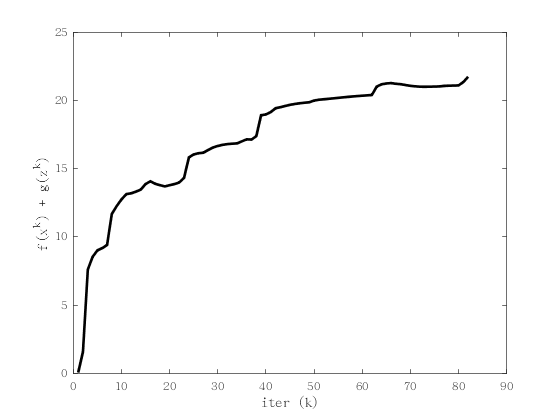

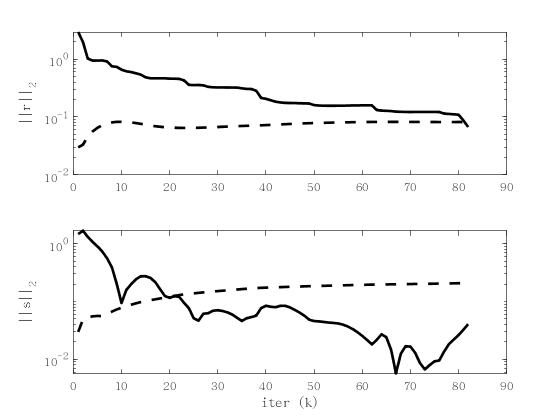

In [6]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');